In [1]:
! git clone https://github.com/AntonOkhotnikov/ai-talent-hub-itmo-speech-course.git
! mv /content/ai-talent-hub-itmo-speech-course/assignments/assignment2/examples ./
! mv /content/ai-talent-hub-itmo-speech-course/assignments/assignment2/lm ./

Cloning into 'ai-talent-hub-itmo-speech-course'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 96 (delta 25), reused 82 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (96/96), 34.96 MiB | 21.06 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [2]:
! pip install https://github.com/kpu/kenlm/archive/master.zip -q
! pip install levenshtein -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.6/553.6 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.3 MB/s eta 0:00:00


In [20]:
from typing import List, Tuple

import kenlm
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC


class Wav2Vec2Decoder:
    def __init__(
            self,
            model_name="facebook/wav2vec2-base-960h",
            lm_model_path="lm/3-gram.pruned.1e-7.arpa.gz",
            beam_width=3,
            alpha=1.0,
            beta=1.0
        ):
        """
        Initialization of Wav2Vec2Decoder class

        Args:
            model_name (str): Pretrained Wav2Vec2 model from transformers
            lm_model_path (str): Path to the KenLM n-gram model (for LM rescoring)
            beam_width (int): Number of hypotheses to keep in beam search
            alpha (float): LM weight for shallow fusion and rescoring
            beta (float): Word bonus for shallow fusion
        """
        # once logits are available, no other interactions with the model are allowed
        self.processor = Wav2Vec2Processor.from_pretrained(model_name)
        self.model = Wav2Vec2ForCTC.from_pretrained(model_name)

        # you can interact with these parameters
        self.vocab = {i: c for c, i in self.processor.tokenizer.get_vocab().items()}
        self.blank_token_id = self.processor.tokenizer.pad_token_id
        self.word_delimiter = self.processor.tokenizer.word_delimiter_token
        self.beam_width = beam_width
        self.alpha = alpha
        self.beta = beta
        self.lm_model = kenlm.Model(lm_model_path) if lm_model_path else None

    def greedy_decode(self, logits: torch.Tensor) -> str:
        """
        Perform greedy decoding (find best CTC path)

        Args:
            logits (torch.Tensor): Logits from Wav2Vec2 model (T, V)

        Returns:
            str: Decoded transcript
        """
        result = []
        for logit in logits:
            result.append(self.vocab[logit.argmax().item()])
        processed = str()
        for i in range(1, len(result)):
            if result[i] != result[i-1]:
                if result[i] != '<pad>':
                    processed += result[i] if result[i] != '|' else ' '
        return processed

    def beam_search_decode(self, logits: torch.Tensor, return_beams: bool = False):
        """
        Perform beam search decoding (no LM)

        Args:
            logits (torch.Tensor): Logits from Wav2Vec2 model (T, V)
            return_beams (bool): Return all beam hypotheses along with their scores

        Returns:
            Union[str, List[Tuple[str, float]]]:
                - (str): The best decoded transcript if return_beams is False.
                - (List[Tuple[str, float]]): List of (transcript, score) tuples if return_beams is True.
        """
        log_probs = torch.log_softmax(logits, dim=-1)
        T, V = log_probs.shape

        # Initialize beams: list of tuples (sequence of token indices, cumulative log prob)
        beams = [([], 0.0)]

        for t in range(T):
            new_beams = []
            # Get log probabilities for the current time step (vector of size V)
            time_step_log_probs = log_probs[t]
            # Extend each beam by the top beam_width tokens
            for seq, score in beams:
                topk_log_probs, topk_indices = torch.topk(time_step_log_probs, self.beam_width)
                for log_prob, token_idx in zip(topk_log_probs.tolist(), topk_indices.tolist()):
                    new_seq = seq + [token_idx]
                    new_score = score + log_prob
                    new_beams.append((new_seq, new_score))
            # Keep only the top beam_width beams
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:self.beam_width]

        # Helper function: collapse repeated tokens and remove blanks
        def collapse_and_map(seq):
            collapsed = []
            previous = None
            for token_idx in seq:
                # If token is blank, reset previous token (CTC property)
                if token_idx == self.blank_token_id:
                    previous = None
                    continue
                if token_idx != previous:
                    collapsed.append(token_idx)
                    previous = token_idx
            # Map token indices to characters using self.vocab
            transcript = "".join(self.vocab.get(token, "") for token in collapsed)
            # Replace word delimiter with a space if applicable
            transcript = transcript.replace(self.word_delimiter, " ")
            return transcript

        # Apply CTC collapsing and mapping for each beam
        decoded_beams = [(collapse_and_map(seq), score) for seq, score in beams]

        if return_beams:
            return decoded_beams
        else:
            return decoded_beams[0][0]


    def beam_search_with_lm(self, logits: torch.Tensor) -> str:
        """
        Use beam search with shallow LM fusion to decode logits.

        Args:
            logits (torch.Tensor): Logits from Wav2Vec2 model (T, V) where T is the time steps and V is the vocabulary size.

        Returns:
            str: The decoded transcript.
        """
        if not self.lm_model:
            raise ValueError("KenLM model required for LM shallow fusion")

        import heapq

        # Compute log probabilities
        log_probs = torch.log_softmax(logits, dim=-1)
        T, V = log_probs.shape

        # Each beam element is a tuple: (total_score, acoustic_score, token_ids, last_token, transcript_so_far)
        beams = [(0.0, 0.0, [], self.blank_token_id, "")]

        for t in range(T):
            candidates = []
            for total, am_score, token_seq, last_tok, transcript in beams:
                # Option 1: Extend with a blank (no new character)
                blank_am = am_score - log_probs[t, self.blank_token_id].item()
                candidates.append((blank_am, blank_am, token_seq, self.blank_token_id, transcript))

                # Option 2: Extend with a non-blank token
                for token_id in range(V):
                    if token_id == self.blank_token_id:
                        continue

                    char = self.vocab[token_id]
                    new_am = am_score - log_probs[t, token_id].item()

                    if token_id != last_tok:
                        new_seq = token_seq + [token_id]
                        new_transcript = transcript + char

                        # Apply LM bonus when a word delimiter or space is produced.
                        lm_bonus = 0.0
                        if char in (self.word_delimiter, ' '):
                            words = new_transcript.replace(self.word_delimiter, ' ').split()
                            if words:
                                last_word = words[-1]
                                lm_bonus = self.lm_model.score(last_word, bos=True, eos=False)
                                lm_bonus += self.beta

                        # Total score penalizes LM score weighted by alpha.
                        new_total = new_am - self.alpha * lm_bonus
                        candidates.append((new_total, new_am, new_seq, token_id, new_transcript))
                    else:
                        # If token repeats, do not update transcript
                        candidates.append((new_am, new_am, token_seq, token_id, transcript))

            # Keep the best beam_width candidates.
            beams = heapq.nsmallest(self.beam_width, candidates, key=lambda x: x[0])

        # Finalize the hypothesis from the beam with the best LM-adjusted score.
        best_hypo = None
        best_final_score = float('-inf')
        for total, am, token_seq, _, _ in beams:
            dedup_seq = []
            prev = None
            for t_id in token_seq:
                if t_id != prev:
                    dedup_seq.append(t_id)
                prev = t_id
            candidate = ''.join(self.vocab[tok] for tok in dedup_seq)
            candidate = candidate.replace(self.word_delimiter, ' ')
            lm_final = self.lm_model.score(candidate)
            final_score = -total + self.alpha * lm_final

            if final_score > best_final_score:
                best_final_score = final_score
                best_hypo = candidate

        return best_hypo



    def lm_rescore(self, beams: List[Tuple[str, float]]) -> str:
        """
        Perform second-pass LM rescoring on beam search outputs.

        Args:
            beams (list): List of tuples (hypothesis, acoustic_log_prob)

        Returns:
            str: Best rescored transcript
        """
        if not self.lm_model:
            raise ValueError("KenLM model required for LM rescoring")

        best_score = -float("inf")
        best_hypothesis = ""
        for hypothesis, acoustic_score in beams:
            candidate = hypothesis.strip()
            if candidate:
                lm_score = self.lm_model.score(candidate, bos=True, eos=True)
                word_count = candidate.count(" ") + 1
                combined_score = acoustic_score + self.alpha * lm_score + self.beta * word_count
            else:
                combined_score = acoustic_score
            if combined_score > best_score:
                best_score = combined_score
                best_hypothesis = candidate
        return best_hypothesis


    def decode(self, audio_input: torch.Tensor, method: str = "greedy") -> str:
        """
        Decode input audio file using the specified method

        Args:
            audio_input (torch.Tensor): Audio tensor
            method (str): Decoding method ("greedy", "beam", "beam_lm", "beam_lm_rescore"),
                where "greedy" is a greedy decoding,
                      "beam" is beam search without LM,
                      "beam_lm" is beam search with LM shallow fusion, and
                      "beam_lm_rescore" is a beam search with second pass LM rescoring

        Returns:
            str: Decoded transcription
        """
        inputs = self.processor(audio_input, return_tensors="pt", sampling_rate=16000)
        with torch.no_grad():
            logits = self.model(inputs.input_values.squeeze(0)).logits[0]

        if method == "greedy":
            return self.greedy_decode(logits)
        elif method == "beam":
            return self.beam_search_decode(logits)
        elif method == "beam_lm":
            return self.beam_search_with_lm(logits)
        elif method == "beam_lm_rescore":
            beams = self.beam_search_decode(logits, return_beams=True)
            return self.lm_rescore(beams)
        else:
            raise ValueError("Invalid decoding method. Choose one of 'greedy', 'beam', 'beam_lm', 'beam_lm_rescore'.")


def test(decoder, audio_path, true_transcription):

    import Levenshtein

    audio_input, sr = torchaudio.load(audio_path)
    assert sr == 16000, "Audio sample rate must be 16kHz"

    print("=" * 60)
    print("Target transcription")
    print(true_transcription)

    # Print all decoding methods results
    for d_strategy in ["greedy", "beam", "beam_lm", "beam_lm_rescore"]:
        print("-" * 60)
        print(f"{d_strategy} decoding")
        transcript = decoder.decode(audio_input, method=d_strategy)
        # print(f"{transcript}")
        print(f"Character-level Levenshtein distance: {Levenshtein.distance(true_transcription, transcript.strip())}")



In [15]:
test_samples = [
    ("examples/sample1.wav", "IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUNITY FOR THE EXERCISE OF YOUR MAGNANIMITY IF YOU ARE PROUD HERE AM I YOUR RIVAL READY TO ACKNOWLEDGE MYSELF YOUR DEBTOR FOR AN ACT OF THE MOST NOBLE FORBEARANCE"),
    ("examples/sample2.wav", "AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKETS OF THEIR OWN IZZY WAS UNDOUBTEDLY THE MAN TO FIND IT OUT AND USE THE INFORMATION WITH A BEAT SUCH AS THAT EVEN GOING HALVES AND WITH ALL THE GRAFT TO THE UPPER BRACKETS HE'D STILL BE ABLE TO MAKE HIS PILE IN A MATTER OF MONTHS"),
    ("examples/sample3.wav", "GUESS A MAN GETS USED TO ANYTHING HELL MAYBE I CAN HIRE SOME BUMS TO SIT AROUND AND WHOOP IT UP WHEN THE SHIPS COME IN AND BILL THIS AS A REAL OLD MARTIAN DEN OF SIN"),
    ("examples/sample4.wav", "IT WAS A TUNE THEY HAD ALL HEARD HUNDREDS OF TIMES SO THERE WAS NO DIFFICULTY IN TURNING OUT A PASSABLE IMITATION OF IT TO THE IMPROVISED STRAINS OF I DIDN'T WANT TO DO IT THE PRISONER STRODE FORTH TO FREEDOM"),
    ("examples/sample5.wav", "MARGUERITE TIRED OUT WITH THIS LONG CONFESSION THREW HERSELF BACK ON THE SOFA AND TO STIFLE A SLIGHT COUGH PUT UP HER HANDKERCHIEF TO HER LIPS AND FROM THAT TO HER EYES"),
    ("examples/sample6.wav", "AT THIS TIME ALL PARTICIPANTS ARE IN A LISTEN ONLY MODE"),
    ("examples/sample7.wav", "THE INCREASE WAS MAINLY ATTRIBUTABLE TO THE NET INCREASE IN THE AVERAGE SIZE OF OUR FLEETS"),
    ("examples/sample8.wav", "OPERATING SURPLUS IS A NON CAP FINANCIAL MEASURE WHICH IS DEFINED AS FULLY IN OUR PRESS RELEASE"),
]

decoder = Wav2Vec2Decoder()


_ = [test(decoder, audio_path, target) for audio_path, target in test_samples]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Target transcription
IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUNITY FOR THE EXERCISE OF YOUR MAGNANIMITY IF YOU ARE PROUD HERE AM I YOUR RIVAL READY TO ACKNOWLEDGE MYSELF YOUR DEBTOR FOR AN ACT OF THE MOST NOBLE FORBEARANCE
------------------------------------------------------------
greedy decoding
IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUNITY FOR THE EXERCISE OF YOUR MAGNANIMITY IF YOU ARE PROUD HERE AM I YOUR RIVAL RETER TO ACKNOWLEDGE MYSELF YOUR DEPTOR FOR AN ACT OF MOST NOBLE FORBEARANCE 
Character-level Levenshtein distance: 8
------------------------------------------------------------
beam decoding
IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUNITY FOR THE EXERCISE OF YOUR MAGNANIMITY IF YOU ARE PROUD HERE AM I YOUR RIVAL RETER TO ACKNOWLEDGE MYSELF YOUR DEPTOR FOR AN ACT OF MOST NOBLE FORBEARANCE 
Character-level Levenshtein distance: 8
------------------------------------------------------------
beam_lm decoding
IF YOU ARE GENEROUS HERE IS A FITING OPORTUNITY FOR THE E

In [17]:
! wget https://www.openslr.org/resources/11/4-gram.arpa.gz
! mv 4-gram.arpa.gz ./lm

In [18]:
test_samples = [
    ("examples/sample1.wav", "IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUNITY FOR THE EXERCISE OF YOUR MAGNANIMITY IF YOU ARE PROUD HERE AM I YOUR RIVAL READY TO ACKNOWLEDGE MYSELF YOUR DEBTOR FOR AN ACT OF THE MOST NOBLE FORBEARANCE"),
    ("examples/sample2.wav", "AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKETS OF THEIR OWN IZZY WAS UNDOUBTEDLY THE MAN TO FIND IT OUT AND USE THE INFORMATION WITH A BEAT SUCH AS THAT EVEN GOING HALVES AND WITH ALL THE GRAFT TO THE UPPER BRACKETS HE'D STILL BE ABLE TO MAKE HIS PILE IN A MATTER OF MONTHS"),
    ("examples/sample3.wav", "GUESS A MAN GETS USED TO ANYTHING HELL MAYBE I CAN HIRE SOME BUMS TO SIT AROUND AND WHOOP IT UP WHEN THE SHIPS COME IN AND BILL THIS AS A REAL OLD MARTIAN DEN OF SIN"),
    ("examples/sample4.wav", "IT WAS A TUNE THEY HAD ALL HEARD HUNDREDS OF TIMES SO THERE WAS NO DIFFICULTY IN TURNING OUT A PASSABLE IMITATION OF IT TO THE IMPROVISED STRAINS OF I DIDN'T WANT TO DO IT THE PRISONER STRODE FORTH TO FREEDOM"),
    ("examples/sample5.wav", "MARGUERITE TIRED OUT WITH THIS LONG CONFESSION THREW HERSELF BACK ON THE SOFA AND TO STIFLE A SLIGHT COUGH PUT UP HER HANDKERCHIEF TO HER LIPS AND FROM THAT TO HER EYES"),
    ("examples/sample6.wav", "AT THIS TIME ALL PARTICIPANTS ARE IN A LISTEN ONLY MODE"),
    ("examples/sample7.wav", "THE INCREASE WAS MAINLY ATTRIBUTABLE TO THE NET INCREASE IN THE AVERAGE SIZE OF OUR FLEETS"),
    ("examples/sample8.wav", "OPERATING SURPLUS IS A NON CAP FINANCIAL MEASURE WHICH IS DEFINED AS FULLY IN OUR PRESS RELEASE"),
]

decoder = Wav2Vec2Decoder(lm_model_path="/content/lm/4-gram.arpa.gz")


_ = [test(decoder, audio_path, target) for audio_path, target in test_samples]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Target transcription
IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUNITY FOR THE EXERCISE OF YOUR MAGNANIMITY IF YOU ARE PROUD HERE AM I YOUR RIVAL READY TO ACKNOWLEDGE MYSELF YOUR DEBTOR FOR AN ACT OF THE MOST NOBLE FORBEARANCE
------------------------------------------------------------
greedy decoding
IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUNITY FOR THE EXERCISE OF YOUR MAGNANIMITY IF YOU ARE PROUD HERE AM I YOUR RIVAL RETER TO ACKNOWLEDGE MYSELF YOUR DEPTOR FOR AN ACT OF MOST NOBLE FORBEARANCE 
Character-level Levenshtein distance: 8
------------------------------------------------------------
beam decoding
IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUNITY FOR THE EXERCISE OF YOUR MAGNANIMITY IF YOU ARE PROUD HERE AM I YOUR RIVAL RETER TO ACKNOWLEDGE MYSELF YOUR DEPTOR FOR AN ACT OF MOST NOBLE FORBEARANCE 
Character-level Levenshtein distance: 8
------------------------------------------------------------
beam_lm decoding
IF YOU ARE GENEROUS HERE IS A FITING OPORTUNITY FOR THE E

In [22]:
# Updated test function that collects metrics
def collect_metrics(decoder, test_samples):
    """
    For each test sample, decode with all methods and compute character-level Levenshtein distance.

    Returns:
        A dictionary with average distances for each method.
    """
    metrics = {"greedy": [], "beam": [], "beam_lm": [], "beam_lm_rescore": []}
    for audio_path, true_transcription in test_samples:
        audio_input, sr = torchaudio.load(audio_path)
        assert sr == 16000, "Audio sample rate must be 16kHz"
        for method in ["greedy", "beam", "beam_lm", "beam_lm_rescore"]:
            transcript = decoder.decode(audio_input, method=method)
            dist = Levenshtein.distance(true_transcription, transcript.strip())
            metrics[method].append(dist)
    # Compute average Levenshtein distance per method over all samples.
    avg_metrics = {method: sum(dist_list) / len(dist_list) for method, dist_list in metrics.items()}
    return avg_metrics

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']

    greedy  beam  beam_lm  beam_lm_rescore  beam_width  alpha  beta  \
0      7.5   7.5   10.875            7.500           3    0.5   0.5   
1      7.5   7.5   10.500            7.500           3    0.5   1.0   
2      7.5   7.5   10.500            7.500           3    0.5   1.5   
3      7.5   7.5   10.875            7.500           3    1.0   0.5   
4      7.5   7.5   10.750            7.500           3    1.0   1.0   
5      7.5   7.5   10.750            7.500           3    1.0   1.5   
6      7.5   7.5   12.750            7.500           3    1.5   0.5   
7      7.5   7.5   12.250            7.500           3    1.5   1.0   
8      7.5   7.5   11.625            7.500           3    1.5   1.5   
9      7.5   7.5   10.750            7.625           5    0.5   0.5   
10     7.5   7.5   10.500            7.625           5    0.5   1.0   
11     7.5   7.5   10.375            7.625           5    0.5   1.5   
12     7.5   7.5   10.625            7.625           5    1.0   0.5   
13    

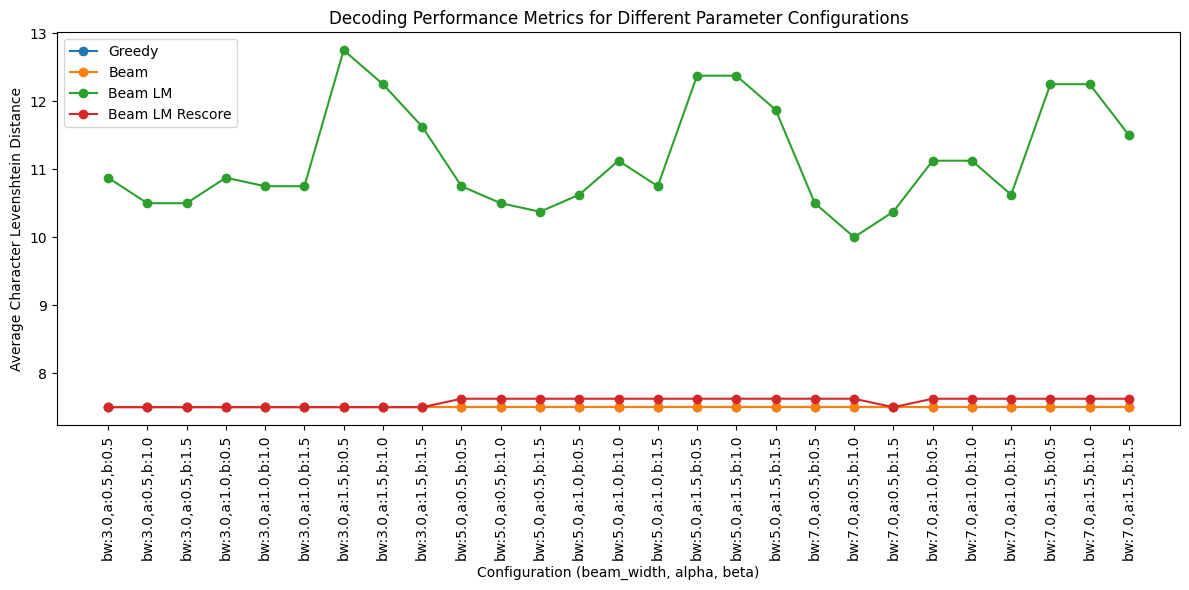

In [24]:
import Levenshtein
import pandas as pd
from matplotlib import pyplot as plt

# Loop over configurations and collect metrics.
results = []
for beam_width in [3, 5, 7]:
    for alpha in [0.5, 1.0, 1.5]:
        for beta in [0.5, 1.0, 1.5]:
            # Instantiate the decoder with this configuration.
            decoder = Wav2Vec2Decoder(beam_width=beam_width, alpha=alpha, beta=beta)
            avg_metrics = collect_metrics(decoder, test_samples)
            avg_metrics["beam_width"] = beam_width
            avg_metrics["alpha"] = alpha
            avg_metrics["beta"] = beta
            results.append(avg_metrics)

# Create a DataFrame from the results.
df = pd.DataFrame(results)
# Create a column for configuration labels.
df["config"] = df.apply(lambda row: f"bw:{row['beam_width']},a:{row['alpha']},b:{row['beta']}", axis=1)

print(df)

# Plot average Levenshtein distances for each method for all configurations.
plt.figure(figsize=(12, 6))
plt.plot(df["config"], df["greedy"], marker='o', label="Greedy")
plt.plot(df["config"], df["beam"], marker='o', label="Beam")
plt.plot(df["config"], df["beam_lm"], marker='o', label="Beam LM")
plt.plot(df["config"], df["beam_lm_rescore"], marker='o', label="Beam LM Rescore")
plt.xlabel("Configuration (beam_width, alpha, beta)")
plt.ylabel("Average Character Levenshtein Distance")
plt.title("Decoding Performance Metrics for Different Parameter Configurations")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()